In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from scipy.stats import zscore
import statsmodels.api as sm

################################
## Regression and Clustering after PCA
################################

In [138]:
np.random.seed(1234)

# Read the CSV file
dupont = pd.read_csv("/Users/mingzhangyin/Dropbox (UFL)/UF teaching/My course/8-PPCA, Factor model/dupont_data.csv")
print(dupont.head())



   Id  Export  Size  Revenue  Years  Numprod  Q1  Q2  Q3  Q4  ...  SD1  SD2  \
0   1       3    54      4.0    6.5        7   8   8   5   9  ...    9    9   
1   2       2    45      2.0    6.0        6   9   9   9   9  ...    9    9   
2   3       1    44      2.0    5.8       11  10   4   2   7  ...   10   10   
3   4       3    46      1.0    7.0        3   8   8  10  10  ...    9    9   
4   5       3    46      3.0    6.5        8   9   9   7   9  ...    8    8   

   SD3  SD4  SD5  SD6  SD7  INN1  INN2  INN3  
0    7    7    6    9    9     8     6     6  
1    9    9    9    8   10     9     9     9  
2   10   10    8   10    5     7     2     8  
3    5    5    8   10    9     1     1     1  
4    9    9    8    9   10     8     7     8  

[5 rows x 25 columns]


In [139]:
# Extract survey questions
survqs = dupont.iloc[:, 6:25]

# Revenue regression
X = dupont.drop(columns=['Id', 'Revenue'])
X = sm.add_constant(X)
y = dupont['Revenue']
revreg = sm.OLS(y, X).fit()
print(revreg.summary())



                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     1.759
Date:                Tue, 18 Apr 2023   Prob (F-statistic):             0.0658
Time:                        19:08:05   Log-Likelihood:                -50.971
No. Observations:                  58   AIC:                             149.9
Df Residuals:                      34   BIC:                             199.4
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0628      2.247      0.918      0.3

### **K-means clustering: can we distinguish long-time customer by survey response?**

(3.0, 9.0)

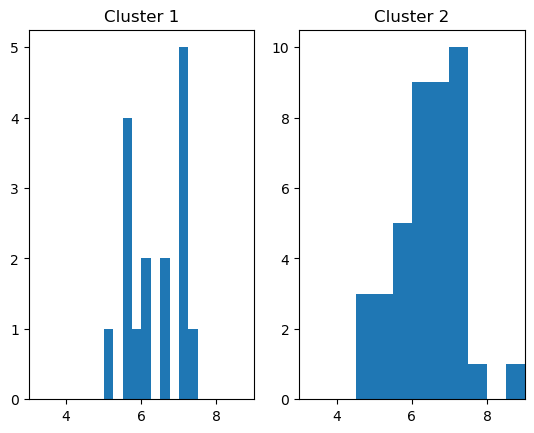

In [140]:
kmeans_result = KMeans(n_clusters=2).fit(zscore(survqs))
plt.subplot(1, 2, 1)
plt.hist(dupont.Years[ kmeans_result.labels_ == 0])
plt.title('Cluster 1')
plt.xlim([3,9])
plt.subplot(1, 2, 2)
plt.hist(dupont.Years[ kmeans_result.labels_ == 1])
plt.title('Cluster 2')
plt.xlim([3,9])

In [141]:
kmeans_result.cluster_centers_

array([[-0.77719595, -0.91002396, -0.98477468, -0.55951532, -1.03731131,
        -0.95738715, -0.96952735, -1.03498384, -1.06540067, -0.63876049,
        -0.50026896, -0.99010105, -0.9223304 , -0.48970936, -0.4375    ,
        -0.76459281, -0.76140465, -1.11471183, -0.77804097],
       [ 0.29607465,  0.34667579,  0.37515226,  0.21314869,  0.39516621,
         0.36471891,  0.36934375,  0.39427956,  0.40586692,  0.24333733,
         0.19057865,  0.37718135,  0.35136396,  0.18655595,  0.16666667,
         0.29127345,  0.29005891,  0.42465213,  0.29639656]])

### **Principle component analysis (PCA)**

### Choose the number of principle components

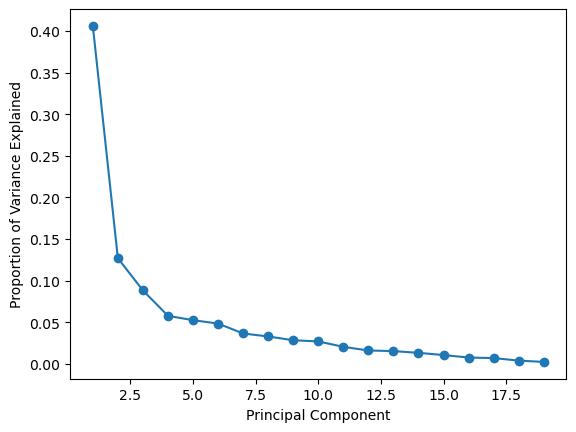

In [142]:

fullpca = PCA().fit(zscore(survqs))

# Scree plot to choose the best number of components

plt.plot(np.arange(1, len(fullpca.explained_variance_ratio_) + 1), fullpca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [143]:
# PCA with 4 components. The number of components we choose is 4 based on the scree plot

f4 = PCA(n_components=4).fit_transform(zscore(survqs))



In [144]:
survqs.shape

(58, 19)

In [145]:
f4.shape

(58, 4)

### **K-means clustering over PCA: can we distinguish long-time customer by survey response?**

(3.0, 9.0)

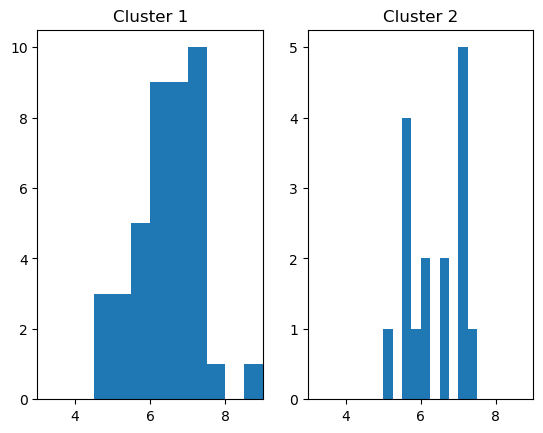

In [146]:
fsc2 = KMeans(n_clusters=2).fit(f4)

plt.subplot(1, 2, 1)
plt.hist(dupont.Years[ fsc2.labels_ == 0])
plt.title('Cluster 1')
plt.xlim([3,9])
plt.subplot(1, 2, 2)
plt.hist(dupont.Years[ fsc2.labels_ == 1])
plt.title('Cluster 2')
plt.xlim([3,9])

In [162]:
dupont.columns

Index(['Id', 'Export', 'Size', 'Revenue', 'Years', 'Numprod', 'Q1', 'Q2', 'Q3',
       'Q4', 'TS1', 'TS2', 'TS3', 'SM1', 'SM2', 'SD1', 'SD2', 'SD3', 'SD4',
       'SD5', 'SD6', 'SD7', 'INN1', 'INN2', 'INN3'],
      dtype='object')

In [169]:
export_cluster0 = dupont['Export'][fsc2.labels_ == 0]
sum(export_cluster0 == 3)

16

### Regression by PCA segments, using X and principle components

In [147]:

c1_data = dupont.iloc[fsc2.labels_ == 0]
c1_X = c1_data[["Export","Size","Years","Numprod"]].reset_index(drop=True).join(pd.DataFrame(f4[fsc2.labels_ == 0, :], columns=[f'PC{i+1}' for i in range(4)]))
c1_X = sm.add_constant(c1_X)
c1_y = c1_data['Revenue'].reset_index(drop=True)
c1reg = sm.OLS(c1_y.values, c1_X.values).fit()
print(c1reg.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     1.380
Date:                Tue, 18 Apr 2023   Prob (F-statistic):              0.242
Time:                        19:08:08   Log-Likelihood:                -44.437
No. Observations:                  42   AIC:                             106.9
Df Residuals:                      33   BIC:                             122.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1342      1.109      1.023      0.3

In [148]:

c2_data = dupont.iloc[fsc2.labels_ == 1]
c2_X = c2_data[["Export","Size","Years","Numprod"]].reset_index(drop=True).join(pd.DataFrame(f4[fsc2.labels_ == 1, :], columns=[f'PC{i+1}' for i in range(4)]))
c2_X = sm.add_constant(c2_X)
c2_y = c2_data['Revenue']
c2reg = sm.OLS(c2_y.values, c2_X.values).fit()
print(c2reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     1.228
Date:                Tue, 18 Apr 2023   Prob (F-statistic):              0.400
Time:                        19:08:08   Log-Likelihood:                -15.346
No. Observations:                  16   AIC:                             48.69
Df Residuals:                       7   BIC:                             55.65
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6579      3.786      1.230      0.2

/Users/mingzhangyin/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


################################
## Factor analysis
################################

In [149]:
# pip install factor_analyzer
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Read the CSV file
mydata = pd.read_csv('/Users/mingzhangyin/Dropbox (UFL)/UF teaching/My course/8-PPCA, Factor model/EFA.csv')



In [150]:
mydata.head()

,Price,Safety,Exterior_Looks,Space_comfort,Technology,After_Sales_Service,Resale_Value,Fuel_Type,Fuel_Efficiency,Color,Maintenance,Test_drive,Product_reviews,Testimonials
0,4,4,5,4,3,4,5,4,4,2,4,2,4,3
1,3,5,3,3,4,4,3,4,3,4,3,2,2,2
2,4,4,3,4,5,5,5,4,5,4,5,4,4,3
3,4,4,4,3,3,4,5,5,4,4,4,2,5,3
4,5,5,4,4,5,4,5,3,4,5,5,5,5,2


In [151]:
mydata.shape

(90, 14)

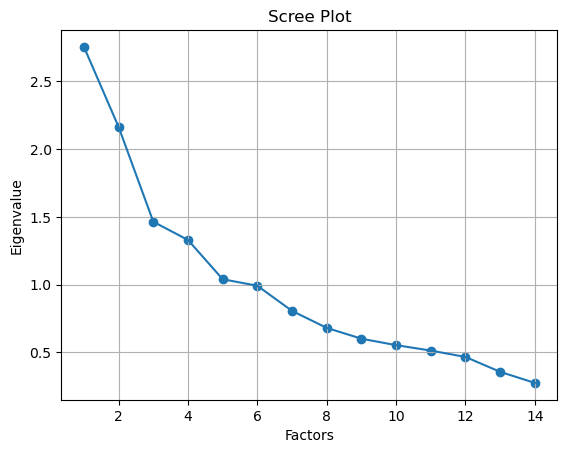

In [152]:
# Determine Number of Factors to Extract
fa = FactorAnalyzer(rotation=None)
#fa.fit(zscore(mydata))
fa.fit(mydata)
ev, v = fa.get_eigenvalues()
plt.scatter(range(1, mydata.shape[1] + 1), ev)
plt.plot(range(1, mydata.shape[1] + 1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()


<!-- # how does fa.get_eigenvalues() work?
correlation_matrix = mydata.corr()
eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)
print("Eigenvalues:",sorted(eigenvalues)[::-1]) -->

In [153]:

# Extract (and rotate) factors

Nfacs = 4  # This is for four factors. You can change this as needed.
fa = FactorAnalyzer(n_factors=Nfacs, rotation="varimax") # Set whether rotation and its type here

fa.fit(mydata) # Fit the factor model



FactorAnalyzer(n_factors=4, rotation='varimax', rotation_kwargs={})

(14, 4)


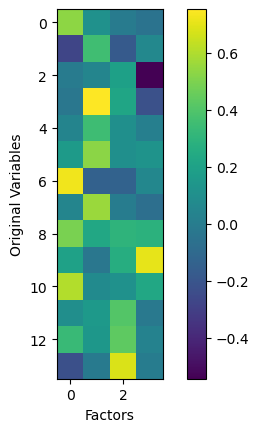

In [154]:
loadings = fa.loadings_
print(np.shape(loadings))
plt.imshow(loadings)
plt.xlabel('Factors')
plt.ylabel('Original Variables')
plt.colorbar()

## Name and interpret the factors

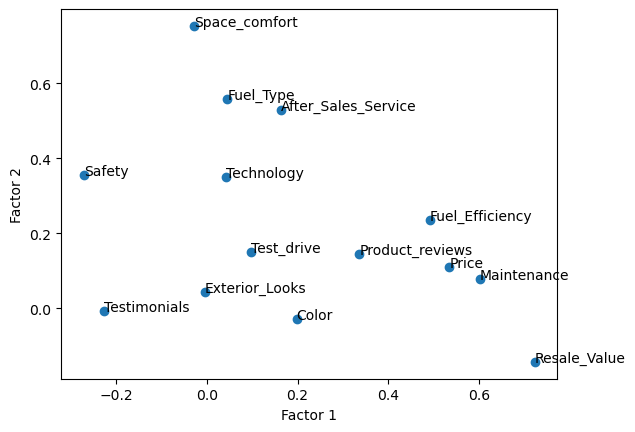

In [155]:
# Plot factor loadings of the first two factors
fig, ax = plt.subplots()
ax.scatter(loadings[:, 0], loadings[:, 1])
for i, txt in enumerate(mydata.columns):
    ax.annotate(txt, (loadings[i, 0], loadings[i, 1]))
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.show()


In [156]:

# Evaluate what you have produced
# Export factor loadings
rounded_loadings = loadings.round(3)

# Create a DataFrame with custom row and column names
loadings_df = pd.DataFrame(rounded_loadings,
                           index=mydata.columns,
                           columns=['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4'])

print(loadings_df)


# Name factors: Aesthetics, Functional Benefits, Economic Value, Credibility
factor_names = ["Economic Value", "Functional Benefits", "Credibility","Aesthetics"]

                     Factor 1  Factor 2  Factor 3  Factor 4
Price                   0.535     0.110    -0.003    -0.050
Safety                 -0.272     0.356    -0.175     0.060
Exterior_Looks         -0.005     0.045     0.193    -0.544
Space_comfort          -0.028     0.753     0.220    -0.223
Technology              0.043     0.349     0.103     0.014
After_Sales_Service     0.163     0.528     0.102     0.124
Resale_Value            0.724    -0.143    -0.137     0.058
Fuel_Type               0.044     0.557    -0.000    -0.069
Fuel_Efficiency         0.492     0.235     0.299     0.291
Color                   0.198    -0.029     0.266     0.706
Maintenance             0.603     0.079     0.111     0.233
Test_drive              0.098     0.150     0.407    -0.018
Product_reviews         0.336     0.145     0.429     0.032
Testimonials           -0.228    -0.008     0.677     0.001


In [157]:
loadings_df.columns = factor_names
print(loadings_df)

                     Economic Value  Functional Benefits  Credibility  \
Price                         0.535                0.110       -0.003   
Safety                       -0.272                0.356       -0.175   
Exterior_Looks               -0.005                0.045        0.193   
Space_comfort                -0.028                0.753        0.220   
Technology                    0.043                0.349        0.103   
After_Sales_Service           0.163                0.528        0.102   
Resale_Value                  0.724               -0.143       -0.137   
Fuel_Type                     0.044                0.557       -0.000   
Fuel_Efficiency               0.492                0.235        0.299   
Color                         0.198               -0.029        0.266   
Maintenance                   0.603                0.079        0.111   
Test_drive                    0.098                0.150        0.407   
Product_reviews               0.336                

In [158]:
fa.get_communalities()

array([0.30053289, 0.23454161, 0.33528224, 0.66551579, 0.13449564,
       0.33125026, 0.56618323, 0.31683961, 0.47158197, 0.60918164,
       0.43606222, 0.19807436, 0.31890273, 0.51045761])

In [159]:
fa.phi_

In [160]:
pd.DataFrame(fa.transform(mydata)).head()

,0,1,2,3
0,0.684042,-0.377294,-0.829285,-1.554170
1,-1.319401,-0.604611,-2.172122,0.993007
2,1.092649,0.416129,-0.378641,0.694256
3,0.730056,-0.834151,-0.755207,0.225665
4,1.369498,0.002350,-0.533379,0.661454


In [161]:
?FactorAnalyzer

Init signature:
FactorAnalyzer(
    n_factors=3,
    rotation='promax',
    method='minres',
    use_smc=True,
    is_corr_matrix=False,
    bounds=(0.005, 1),
    impute='median',
    svd_method='randomized',
    rotation_kwargs=None,
)
Docstring:     
The main exploratory factor analysis class.

This class:
    (1) Fits a factor analysis model using minres, maximum likelihood,
        or principal factor extraction and returns the loading matrix
    (2) Optionally performs a rotation, with method including:

        (a) varimax (orthogonal rotation)
        (b) promax (oblique rotation)
        (c) oblimin (oblique rotation)
        (d) oblimax (orthogonal rotation)
        (e) quartimin (oblique rotation)
        (f) quartimax (orthogonal rotation)
        (g) equamax (orthogonal rotation)

Parameters
----------
n_factors : int, optional
    The number of factors to select.
    Defaults to 3.
rotation : str, optional
    The type of rotation to perform after fitting the factor analy